In [4]:
import numpy as np
from Qsim_v4 import *
import matplotlib.pyplot as plt
import networkx as nx

In [6]:
# generating graph
nodes = 20
np.random.seed(10)  # for reproducibility
random.seed(10)
probability = 0.001  # 1, 0.1, 0.01, 0.001
G = gnp_random_connected_graph(nodes, probability)

# Assign properties to edges
for u, v in G.edges():
    G[u][v]['fidelity'] = np.random.uniform(low=0.75, high=0.99)
    G[u][v]['rate'] = np.random.uniform(low=0.85, high=1)
    G[u][v]['pur_round'] = np.random.randint(low=0, high=3)

# Assign properties to nodes
for node in G.nodes():
    G.nodes[node]['swap_success'] = np.random.uniform(low=0.23, high=0.8)

graph_name = f"Random-{nodes}-probability-{probability}"



In [8]:
# Prepare for simulation
N = 10  # Number of iterations
eps = 15000  # Number of episodes per agent
modes = [1, 2, 3]  # Simulation modes
# Generate the random source-destination pairs
#pairs = [(np.random.randint(low=0, high=nodes), np.random.randint(low=0, high=nodes)) for _ in range(N)]
#pairs = [pair for pair in pairs if pair[0] != pair[1]]  # Remove pairs with same source and destination
pairs = [(0, x) for x in range(1, nodes)]
# pairs = [(0, 1)]
mode = 3

max_rewards = np.zeros([100, len(pairs)])
avg_rewards = np.zeros([100, len(pairs)])
min_rewards = np.zeros([100, len(pairs)])
ii = 0
for sn, dest in pairs:
    if ii%10 == 0:
        print(ii, sn, dest)

    agent = QuantumRoutingAgent(G, start_node=sn, destination=dest,
                                    mode=mode, episodes=eps, epsilon=1,
                                    alpha=0.01, gamma=0.9,
                                    qtable="A"+str(sn), save_training=False)

    
    agent.run_simulation_with_data(steps = 10)
    
    avg_rewards[:, ii] = agent.aggr_ep_rewards['avg']/np.abs(np.max(agent.aggr_ep_rewards['max']))
    min_rewards[:, ii] = agent.aggr_ep_rewards['min']/np.abs(np.max(agent.aggr_ep_rewards['max']))
    max_rewards[:, ii] = agent.aggr_ep_rewards['max']/np.abs(np.max(agent.aggr_ep_rewards['max']))
    ii += 1
    
eps_list = agent.aggr_ep_rewards['ep']

0 0 1
Error loading Q-table from qtable-A0.npy: [Errno 2] No such file or directory: 'qtable-A0.npy', generating a new one.
10 0 11


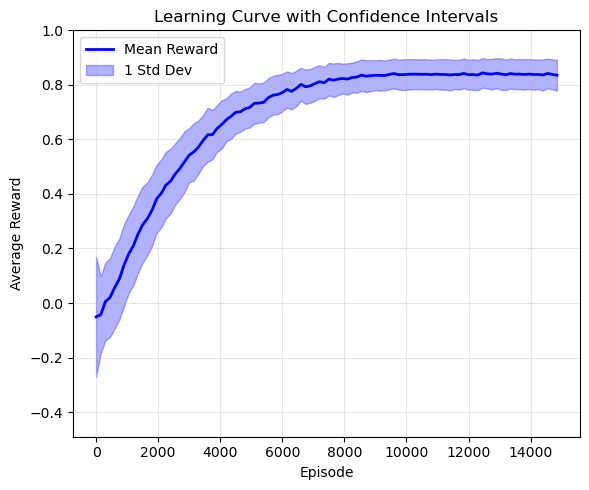

In [10]:
# Calculate mean and standard deviation across runs for each episode
means = np.nanmean(avg_rewards, axis=1)
stds = np.nanstd(avg_rewards, axis=1)

# Create the plot with shadow bands
plt.figure(figsize=(6, 5))

# Plot the mean learning curve
plt.plot(eps_list, means, 'b-', linewidth=2, label='Mean Reward')

# Add shadow bands for ±1 standard deviation
plt.fill_between(eps_list, means - 0.5*stds, means + 0.5*stds, 
                 alpha=0.3, color='blue', label='1 Std Dev')

# Customize the plot
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Learning Curve with Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.legend()

# Optional: Add smoothing if the curve is too noisy
# from scipy.ndimage import gaussian_filter1d
# smoothed_means = gaussian_filter1d(means, sigma=2)
# plt.plot(eps_list, smoothed_means, 'r-', linewidth=2, label='Smoothed Mean')
plt.ylim([min(means - stds), 1])
plt.tight_layout()
plt.show()

In [ ]:
# Calculate mean and standard deviation across runs for each episode
means = np.nanmean(avg_rewards, axis=1)
stds = np.nanstd(avg_rewards, axis=1)

# Create the data array for export
data_columns = [eps_list, means, stds]  # First three columns: episode, mean, std

# Add all individual runs as additional columns
for i in range(avg_rewards.shape[1]):
    data_columns.append(avg_rewards[:, i])

# Combine all columns into a single array
data = np.column_stack(data_columns)

# Create dynamic header
header_parts = ["Episode", "Mean", "Std"]
for i in range(avg_rewards.shape[1]):
    header_parts.append(f"Run_{i+1}")

header = "\t".join(header_parts)

# Save to file
fname = "data_clean_v5/convergence_" + str(mode) + ".dat"
np.savetxt(fname, data, delimiter="\t", 
           header=header, comments="")

print(f"Data exported to " + fname)
print(f"Header: {header}")
print(f"Shape: {data.shape}")